In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst import utils

In [2]:

helios_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/helios.log')

16 3.113229919779467 4.775255936131773 160765.7413120853 0.9223738988996033
20 2.4905839358235733 7.149222381236431 220469.78093530866 0.9255194375275587
24 2.0754866131863117 8.540552327644136 238908.15229295142 0.918971365688526
28 1.778988525588267 11.627796512449118 295376.7726287333 0.9201689725122996
32 1.5566149598897334 15.111540742825259 345794.1028042589 0.9170733051404701
36 1.3836577421242076 19.689731300845416 400652.3964366241 0.9136838656328234
40 1.2452919679117866 26.233642661798797 470339.41387631 0.9116394330151311
44 1.1320836071925333 30.586866482994534 471495.6929640343 0.8973165435543631
48 1.0377433065931558 40.046183023039795 538990.0932391587 0.883999473426829
52 0.9579168983936822 54.269842555722136 638376.7213312429 0.8781004081412987
56 0.8894942627941335 63.716563409012906 655011.6215147123 0.8509625243526285
60 0.8301946452745245 63.919013075516496 514334.8938416931 0.8144137667041345
64 0.7783074799448667 67.44731016016931 416293.46780659695 0.7811182307

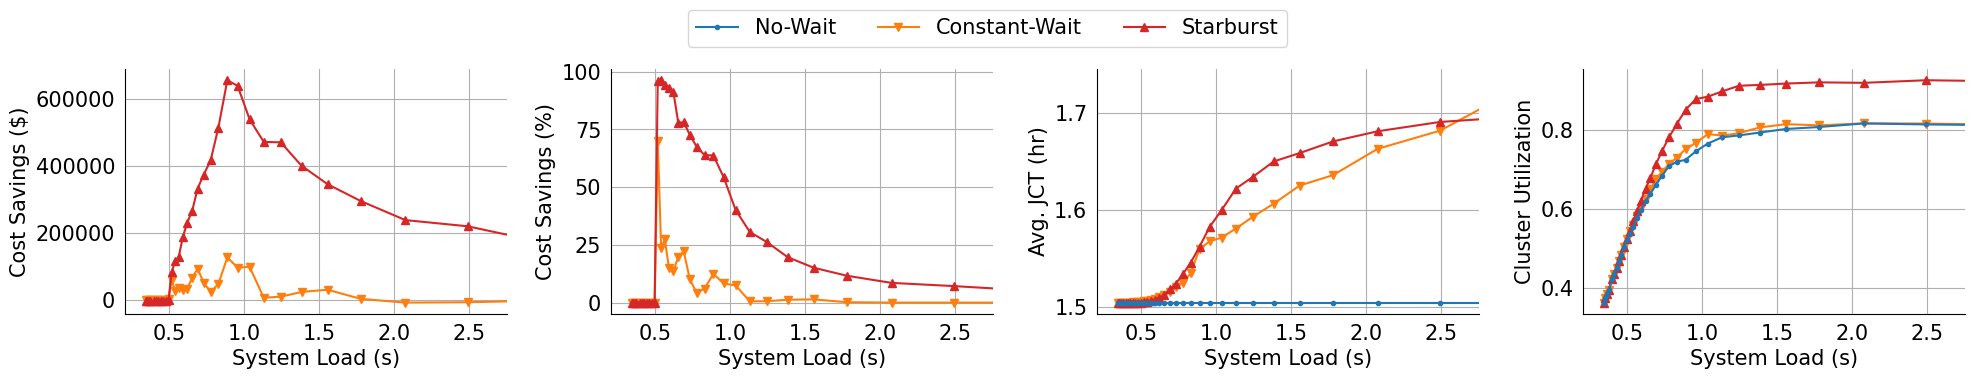

In [7]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=2.75)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    'constant': 'Constant-Wait',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No-Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU',
    'linear_cost_filter_cpu': 'Starburst',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['norm_system_utilization'])
        return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if ax_idx < 2 and label=='No-Wait':
                continue
            color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, color=color, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend([lines[2], lines[0], lines[1]], [labels[2], labels[0], labels[1]], ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    for row in diff_df.iterrows():
        row = row[1]
        if row['waiting_policy_x'] == 'linear_cost_filter_cpu':
            print(row['cluster_size'], row['norm_system_utilization'], row['cost_mult'], row['cost_diff'], row['cluster_utilization_x'])
    plt.savefig('figures/evaluation/helios.pdf', bbox_inches='tight')
    plt.show()  


simulator_plotting_fn(helios_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff', 'cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero'},
                      groupby_values=['waiting_policy'],
                      normalize_x_axis=True)

In [8]:

philly_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/philly.log')

16 3.5287648484368552 2.4763741683610174 45966.26666669996 4.26814263884152 0.9923404568114493
20 2.823011878749484 3.016953495217223 52611.340277805575 4.260646006257738 0.9891958081553298
24 2.3525098989579036 5.215503234310004 85763.06180557556 4.245360679865526 0.9894579874641531
28 2.0164370562496314 6.625036092933801 101950.90763890941 4.235818070550457 0.9862281947563022
32 1.7643824242184276 7.012929336220708 99795.85486111522 4.208533685219461 0.9823737825138684
36 1.5683399326386023 9.237214561867024 121589.31736110972 4.184170223680418 0.9774475030076714
40 1.411505939374742 10.466693528382498 126821.2888888923 4.171335533790613 0.9762034372130028
44 1.2831872176134018 13.484971846402438 149839.68958332538 4.139610837552034 0.9686810263620985
48 1.1762549494789518 15.577194986019837 155456.181944438 4.122546813356832 0.9622907632819644
52 1.0857737995190324 20.267408565738755 183774.74166666376 4.0752707168949796 0.9611822402510303
56 1.0082185281248157 23.998135447485215 19

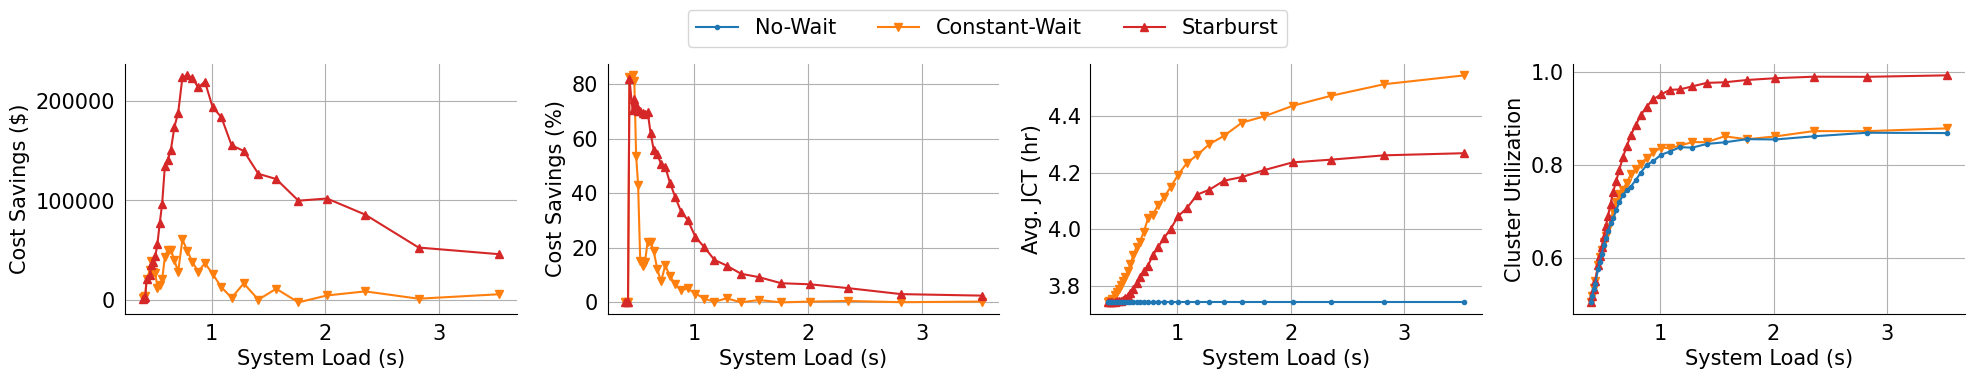

In [10]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(right=2.75)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    'constant': 'Constant-Wait',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Starburst',
    'zero': 'No-Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU',
    'linear_cost_filter_cpu': 'Starburst',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)

    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'

    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
#         if 2.5*(baseline_cost - cost) > 100000:
#             print(row['cluster_size'], row['cost_mult'], row['system_utilization_x'])
        return 2.5*(baseline_cost - cost)
    
#     def fragmentation_fraction(row):
#         system_utilization_norm = min(1, row['norm_system_utilization'])
#         return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
#     diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if ax_idx < 2 and label=='No-Wait':
                continue
            color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, color=color, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend([lines[2], lines[0], lines[1]], [labels[2], labels[0], labels[1]], ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    for row in diff_df.iterrows():
        row = row[1]
        if row['waiting_policy_x'] == 'linear_cost':
            print(row['cluster_size'], row['norm_system_utilization'], row['cost_mult'], row['cost_diff'], row['avg_jct_x'], row['cluster_utilization_x'])
    plt.tight_layout()
    plt.savefig('figures/evaluation/philly.pdf', bbox_inches='tight')
    plt.show()  


simulator_plotting_fn(philly_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff','cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero'},
                      groupby_values=['waiting_policy'],
                      normalize_x_axis=True)

In [11]:
waiting_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/waiting_policies_gen.log')

constant
linear_capacity
linear_cost
linear_runtime
zero


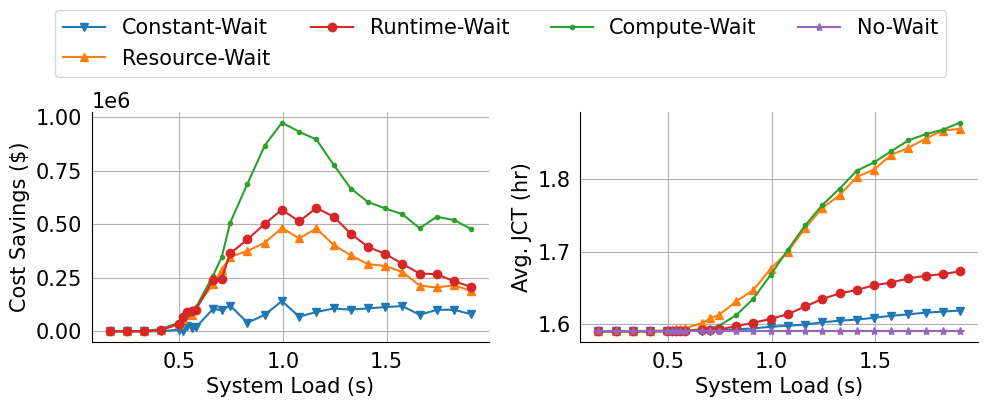

In [13]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    'constant': 'Constant-Wait',
    'linear_runtime': 'Runtime-Wait',
    'linear_cost': 'Compute-Wait',
    'linear_capacity': 'Resource-Wait',
    'zero': 'No-Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU',
    'linear_cost_filter_cpu': 'Starburst',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['norm_system_utilization'])
        return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if ax_idx < 1 and label=='No-Wait':
                continue
            #color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
#     fig.legend([lines[4], lines[0], lines[1], lines[3], lines[2]], \
#                [labels[4], labels[0], labels[1], labels[3], labels[2]], ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    fig.legend([lines[0], lines[1], lines[3], lines[2], lines[4], ], \
               [labels[0], labels[1], labels[3], labels[2], labels[4],], ncol=4, \
               bbox_to_anchor=(0, 1, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/waiting_policies_short.pdf', bbox_inches='tight')
    plt.show()  


# simulator_plotting_fn(waiting_df, x_axis='arrival_rate',  \
#                       y_axis=['cost_mult','cost_diff','avg_jct','cluster_utilization'], \
#                       baseline_filter={'waiting_policy': 'zero'},
#                       groupby_values=['waiting_policy'],
#                       normalize_x_axis=True)

simulator_plotting_fn(waiting_df, x_axis='arrival_rate',  \
                      y_axis=['cost_diff','avg_jct',], \
                      baseline_filter={'waiting_policy': 'zero'},
                      groupby_values=['waiting_policy'],
                      normalize_x_axis=True)

In [110]:
waiting_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/waiting_policies.log')

constant
linear_capacity
linear_cost
linear_runtime
zero


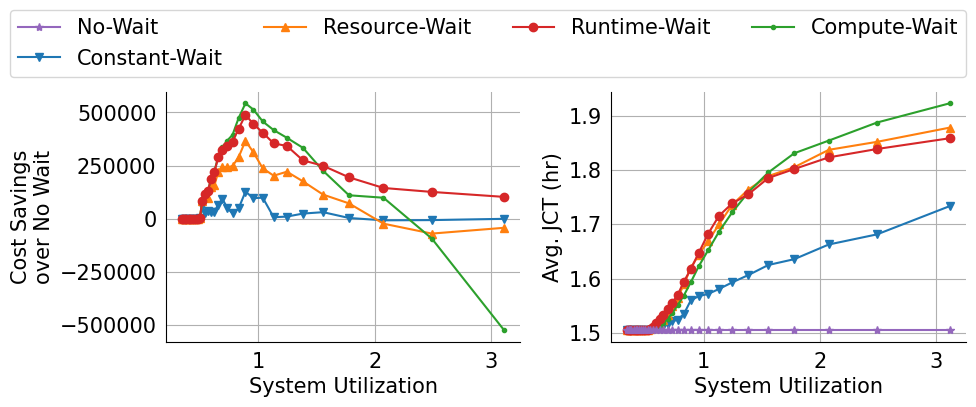

In [183]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    'constant': 'Constant-Wait',
    'linear_runtime': 'Runtime-Wait',
    'linear_cost': 'Compute-Wait',
    'linear_capacity': 'Resource-Wait',
    'zero': 'No-Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU',
    'linear_cost_filter_cpu': 'Starburst',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['norm_system_utilization'])
        return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if ax_idx < 1 and label=='No-Wait':
                continue
            #color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
#     fig.legend([lines[4], lines[0], lines[1], lines[3], lines[2]], \
#                [labels[4], labels[0], labels[1], labels[3], labels[2]], ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    fig.legend([lines[4], lines[0], lines[1], lines[3], lines[2]], \
               [labels[4], labels[0], labels[1], labels[3], labels[2]], ncol=4, \
               bbox_to_anchor=(0, 1, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/waiting_policies_short.pdf', bbox_inches='tight')
    plt.show()  


# simulator_plotting_fn(waiting_df, x_axis='cluster_size',  \
#                       y_axis=['cost_mult','cost_diff','avg_jct','cluster_utilization'], \
#                       baseline_filter={'waiting_policy': 'zero'},
#                       groupby_values=['waiting_policy'],
#                       normalize_x_axis=True)

simulator_plotting_fn(waiting_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff','avg_jct',], \
                      baseline_filter={'waiting_policy': 'zero'},
                      groupby_values=['waiting_policy'],
                      normalize_x_axis=True)

In [14]:
waiting_loop_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/policies_loop_gen.log')

['Constant-Wait', 'Constant-Wait + Loop', 'Compute-Wait', 'Compute-Wait + Loop', 'No-Wait']
5


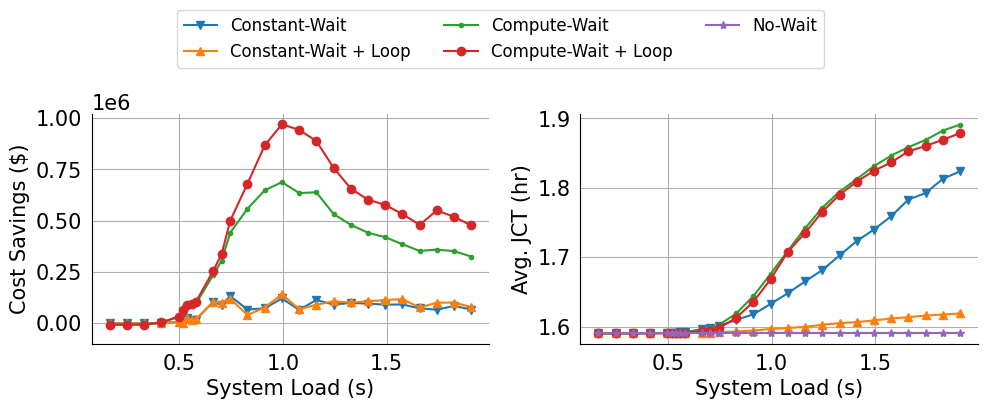

In [16]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    ('constant', 0): 'Constant-Wait',
    ('constant', 1): 'Constant-Wait + Loop',
    ('zero', 0): 'No-Wait',
    ('zero', 1): 'No-Wait + Loop',
    ('linear_cost_filter_cpu', 0): 'Compute-Wait',
    ('linear_cost_filter_cpu', 1): 'Compute-Wait + Loop',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['norm_system_utilization'])
        return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if label == 'No-Wait + Loop':
                continue
            # 2
            if ax_idx < 1 and label=='No-Wait':
                continue
            #color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    print(labels)
    print(len(lines))
    leg = fig.legend([lines[0], lines[1], lines[2], lines[3],lines[4]], \
               [labels[0], labels[1], labels[2], labels[3],labels[4],  ], ncol=3, \
               bbox_to_anchor=(0, 1, 1, 0.2),loc='upper center', fontsize="12")
    axs[0].set_ylim(bottom=-100000)
#     fig.legend([lines[4], lines[0], lines[1], lines[2], lines[3]], \
#                [labels[4], labels[0], labels[1], labels[2], labels[3]], ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/waiting_loop_policies_short.pdf', bbox_inches='tight')
    plt.show()  


# simulator_plotting_fn(waiting_loop_df, x_axis='cluster_size',  \
#                       y_axis=['cost_mult','cost_diff','avg_jct','cluster_utilization'], \
#                       baseline_filter={'waiting_policy': 'zero', 'loop': 0},
#                       groupby_values=['waiting_policy', 'loop'],
#                       normalize_x_axis=True)

simulator_plotting_fn(waiting_loop_df, x_axis='arrival_rate',  \
                      y_axis=['cost_diff','avg_jct'], \
                      baseline_filter={'waiting_policy': 'zero', 'loop': 0},
                      groupby_values=['waiting_policy', 'loop'],
                      normalize_x_axis=True)

In [122]:
jct_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/jct.log')

('linear_runtime', 1000000)
('linear_runtime_filter_cpu', 10)
('linear_runtime_filter_cpu', 1000000)
('zero', 1000000)


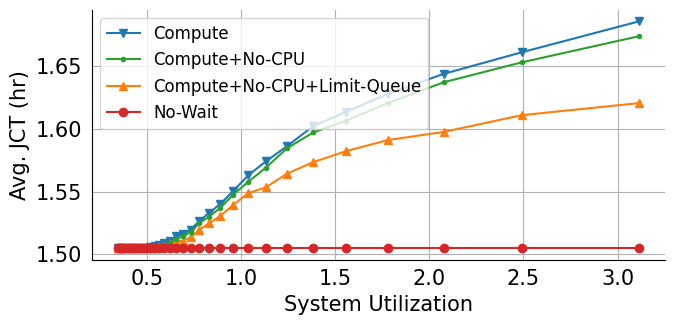

In [126]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    ('linear_runtime', 1000000): 'Compute',
    ('zero', 1000000): 'No-Wait',
    ('linear_runtime_filter_cpu', 10): 'Compute+No-CPU+Limit-Queue',
    ('linear_runtime_filter_cpu', 1000000): 'Compute+No-CPU',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(7*len(y_axis), 3.5))
    axs = [axs]
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['norm_system_utilization'])
        return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if label == 'No-Wait + Loop':
                continue
#             if ax_idx < 2 and label=='No-Wait':
#                 continue
            #color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    axs[0].legend([lines[0], lines[2], lines[1], lines[3]], \
               [labels[0], labels[2], labels[1], labels[3]], prop={'size': 12}, loc='upper left')
    plt.tight_layout()
    plt.savefig('figures/evaluation/jct.pdf', bbox_inches='tight')
    plt.show()  


simulator_plotting_fn(jct_df, x_axis='cluster_size',  \
                      y_axis=['avg_jct'], \
                      baseline_filter={'waiting_policy': 'zero'},
                      groupby_values=['waiting_policy', 'max_queue_length'],
                      normalize_x_axis=True)

In [130]:
no_time_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/no_time_estimator.log')

linear_capacity_filter_cpu
linear_cost_filter_cpu
zero


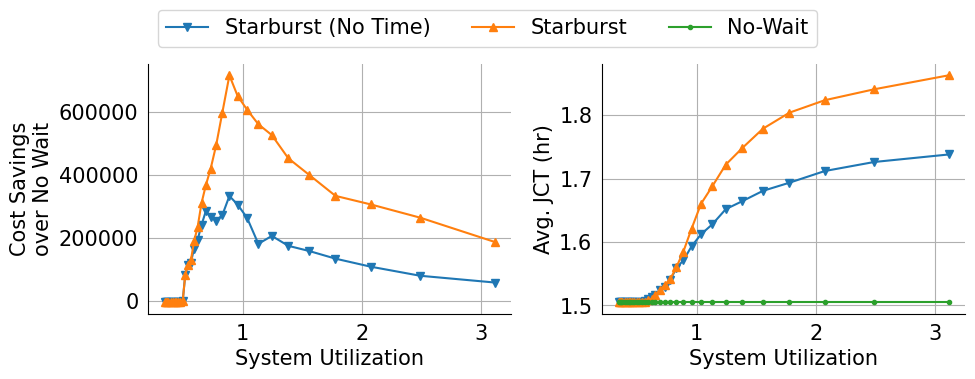

In [147]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    'linear_capacity_filter_cpu': 'Starburst (No Time)',
    'linear_cost_filter_cpu': 'Starburst',
    'zero': 'No-Wait',
    ('linear_runtime', 1000000): 'Compute',
    ('zero', 1000000): 'No-Wait',
    ('linear_runtime_filter_cpu', 10): 'Compute+No-CPU+Limit-Queue',
    ('linear_runtime_filter_cpu', 1000000): 'Compute+No-CPU',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
#     axs = [axs]
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['norm_system_utilization'])
        return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
#             if label == 'No-Wait + Loop':
#                 continue
            if ax_idx < 1 and label=='No-Wait':
                continue
            #color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, \
               labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/no_time_short.pdf', bbox_inches='tight')
    plt.show()  


simulator_plotting_fn(no_time_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff','avg_jct',], \
                      baseline_filter={'waiting_policy': 'zero'},
                      groupby_values=['waiting_policy',],
                      normalize_x_axis=True)

In [17]:
time_error_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/time_estimator_error_gen.log')

('linear_cost_filter_cpu', 0)
('linear_cost_filter_cpu', 10)
('linear_cost_filter_cpu', 25)
('linear_cost_filter_cpu', 50)
('linear_cost_filter_cpu', 100)
('zero', 0)


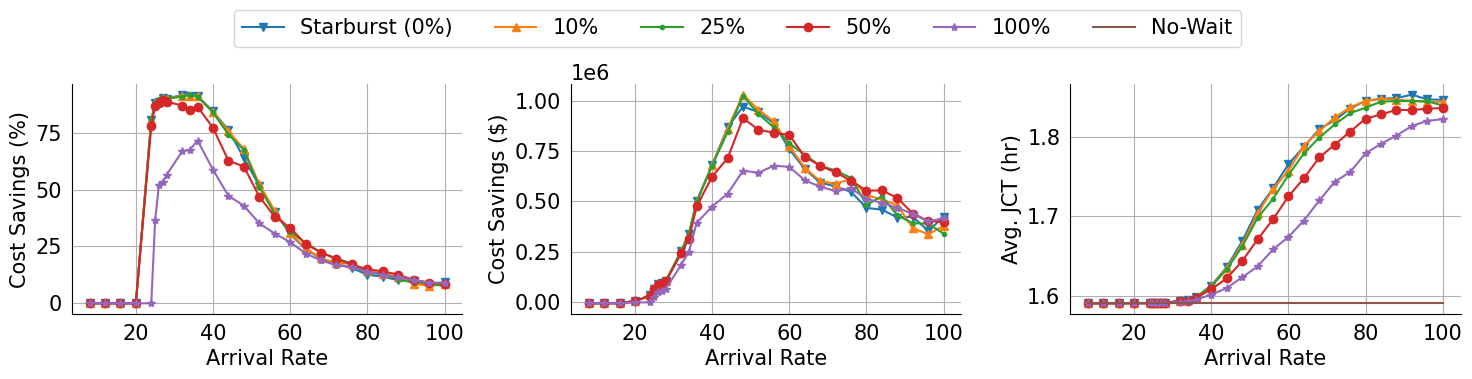

In [28]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    'linear_capacity_filter_cpu': 'Starburst (No Time)',
    'linear_cost_filter_cpu': 'Starburst',
    'zero': 'No-Wait',
    ('linear_runtime', 1000000): 'Compute',
    ('zero', 1000000): 'No-Wait',
    ('linear_runtime_filter_cpu', 10): 'Compute+No-CPU+Limit-Queue',
    ('linear_runtime_filter_cpu', 1000000): 'Compute+No-CPU',
    ('zero', 0): 'No-Wait',
    ('linear_cost_filter_cpu', 0): 'Starburst (0%)',
    ('linear_cost_filter_cpu', 10): '10%',
    ('linear_cost_filter_cpu', 25): '25%',
    ('linear_cost_filter_cpu', 50): '50%',
    ('linear_cost_filter_cpu', 100): '100%',
    
    
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
#     axs = [axs]
    df = df[df['waiting_policy']!='linear_capacity_filter_cpu']
    df = df[df['time_estimator_error']!=500]
    df = df[df['time_estimator_error']!=200]
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
#             if label == 'No-Wait + Loop':
#                 continue
            if ax_idx < 2 and label=='No-Wait':
                continue
            #color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, \
               labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    #plt.savefig('figures/evaluation/time_estimator_short.pdf', bbox_inches='tight')
    plt.show()  


simulator_plotting_fn(time_error_df, x_axis='arrival_rate',  \
                      y_axis = ['cost_mult','cost_diff', 'avg_jct'],
                      #y_axis=['cost_mult','cost_diff','avg_jct', 'cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero'},
                      groupby_values=['waiting_policy','time_estimator_error'],
                      normalize_x_axis=False)

In [20]:
burst_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/burst.log')

('linear_cost_filter_cpu', 1.0)
('linear_cost_filter_cpu', 2.0)
('linear_cost_filter_cpu', 4.0)
('linear_cost_filter_cpu', 8.0)
('zero', 1.0)


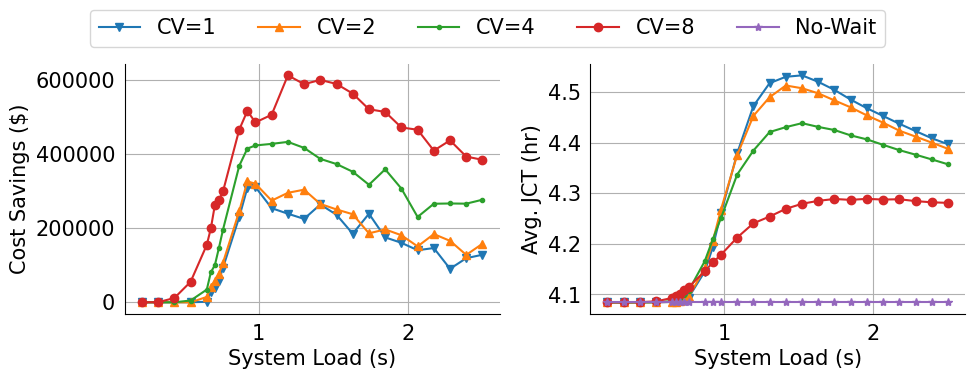

In [22]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    'linear_capacity_filter_cpu': 'Starburst (No Time)',
    'linear_cost_filter_cpu': 'Starburst',
    'zero': 'No-Wait',
    ('linear_runtime', 1000000): 'Compute',
    ('zero', 1000000): 'No-Wait',
    ('linear_runtime_filter_cpu', 10): 'Compute+No-CPU+Limit-Queue',
    ('linear_runtime_filter_cpu', 1000000): 'Compute+No-CPU',
    ('zero', 1): 'No-Wait',
    ('linear_cost_filter_cpu', 1): 'CV=1',
    ('linear_cost_filter_cpu', 2): 'CV=2',
    ('linear_cost_filter_cpu', 4): 'CV=4',
    ('linear_cost_filter_cpu', 8): 'CV=8',
    ('linear_cost_filter_cpu', 100): '100%',
    
    
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
        
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)
    
    list_df = []
    for cv in [1,2,4,8]: #,16,32]:
        cv_df = df[df['cv_factor']==cv]
        cv_zero_df = cv_df[cv_df['waiting_policy'] == 'zero']
        cv_diff_df = pd.merge(cv_df,cv_zero_df, left_on=x_axis,right_on=x_axis)
        cv_diff_df['cost_mult'] = cv_diff_df.apply(cost_multiplier, axis=1)
        cv_diff_df['cost_diff'] = cv_diff_df.apply(cost_difference, axis=1)
        list_df.append(cv_diff_df)
    
    diff_df = pd.concat(list_df, ignore_index=True)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        if label[0] == 'zero' and label[1] !=1:
            continue
        marker = next(markers)
        print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
#             if label == 'No-Wait + Loop':
#                 continue
            if ax_idx < 1 and label=='No-Wait':
                continue
            #color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, \
               labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/burst_short.pdf', bbox_inches='tight')
    plt.show()  


simulator_plotting_fn(burst_df, x_axis='arrival_rate',  \
                      y_axis = ['cost_diff', 'avg_jct'],
                      #y_axis=['cost_mult','cost_diff','avg_jct', 'cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero'},
                      groupby_values=['waiting_policy','cv_factor'],
                      normalize_x_axis=True)